# Attempting to Beat a Zero-Shot Classifier with Classical NLP/ML Techniques

## Overview

This notebook investigates whether a traditional supervised NLP pipeline can outperform a strong **zero-shot baseline** on our real-world book-classification task.

The reference model is the widely used
**`facebook/bart-large-mnli`**, employed in a zero-shot setting to infer book genres from textual description (metadata) - in which it got a 77% accuracy.

Rather than relying on LLMs, we deliberately take steps back into the classical machine learning area to test a simpler hypothesis:

> With sufficient feature engineering and task-specific signal, classical models can compete - and sometimes outperform - zero-shot LLM classifiers - and potentially SOTA LLMs like GPT and DeepSeek.

In [1]:
# Basic Stack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline


In [3]:
import sys
import types

import requests

In [4]:
books_cleaned_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/LLM/book_recommender/data/books_cleaned.csv"
books = pd.read_csv(books_cleaned_url)
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


## Loading Helper Functions from GitHub

To keep this notebook fully portable, helper functions are loaded directly from a raw GitHub file rather than from a local module.
This choice ensures that the notebook can be executed consistently across different environments:

* locally after cloning the repository,
* directly from GitHub,
* or inside runtimes such as Google Colab.

By fetching the utilities at runtime, we avoid fragile relative imports and eliminate problems about local folder structure.
The helper module is dynamically loaded into memory and registered in `sys.modules`, allowing its functions to be accessed exactly like a standard Python package.


In [5]:
def import_from_url(url: str, module_name: str = "remote_module") -> types.ModuleType:
	"""
	Fetches a raw Python script from a URL and loads it as a module.

	Parameters
	----------
	url : str
	    The raw URL of the Python file (e.g., from raw.githubusercontent.com).
	module_name : str
	    The name to assign to the module in sys.modules.

	Returns
	-------
	types.ModuleType
	    The loaded module object.
	"""
	# Fetch the raw code
	response = requests.get(url)
	response.raise_for_status()  # Ensure the request succeeded
	source_code = response.text

	# Create a new, empty module object
	module = types.ModuleType(module_name)

	# Populate the module by executing the source code in its namespace
	# This keeps functions/variables contained within 'module', not global
	exec(source_code, module.__dict__)

	#  Register it in sys.modules
	# This allows other imported modules to see it if necessary.
	sys.modules[module_name] = module

	return module

In [6]:
# GitHub URL
helper_utils_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/LLM/book_recommender/data/utils.py"

# Import it
utils = import_from_url(helper_utils_url, module_name="utils")

# It's now possible to access functions just like a normal package
# df_results = utils.evaluate_candidates_cls(candidates, X, y)
print(f"Module '{utils.__name__}' loaded successfully.")

Module 'utils' loaded successfully.


## Simplifying the Target Categories

The original dataset contains a rich and heterogeneous set of genre labels. While informative, this level of granularity is not statistically practical for supervised modelling with the available data.

To ensure reliable learning and stable evaluation, categories are collapsed into a binary distinction:

**Fiction** vs **Nonfiction**.

This simplification is intentional. The book descriptions themselves remain semantically rich and will later provide sufficient signal for recommendation and similarity tasks with the "Description" feature. However, for classification, the fiction/nonfiction boundary is an extremelly meaningful, well-defined axis that is both realistic and learnable.

In simpler terms:
> semantic richness is preserved in the dataset, while categorical noise is reduced in the labels.


In [7]:
category_mapping = {
	"Fiction": "Fiction",
	"Juvenile Fiction": "Fiction",
	"Biography & Autobiography": "Nonfiction",
	"History": "Nonfiction",
	"Literary Criticism": "Nonfiction",
	"Philosophy": "Nonfiction",
	"Religion": "Nonfiction",
	"Comics & Graphic Novels": "Fiction",
	"Drama": "Fiction",
	"Juvenile Nonfiction": "Nonfiction",
	"Science": "Nonfiction",
	"Poetry": "Fiction",
}

books["simple_categories"] = books["categories"].map(category_mapping)

In [8]:
# Extracting rows that already have labels for training/testing
labelled = books[books["simple_categories"].notna()].copy()
# Extracting rows that need labels
unlabelled = books[books["simple_categories"].isna()].copy()

# Using description for the primary semantic signal
X_labelled = labelled["description"]
y_labelled = labelled["simple_categories"]

X_train, X_test, y_train, y_test = train_test_split(X_labelled, y_labelled, test_size=0.2, random_state=42, stratify=y_labelled)

### Baseline Candidates

Evaluating baseline_logreg...
Evaluating baseline_svc...
  -> baseline_svc lacks native 'predict_proba'. Wrapping in CalibratedClassifierCV (this may be slow).
Evaluating baseline_tree...


,Model,test_roc_auc (mean),test_roc_auc (std),train_roc_auc (mean),train_roc_auc (std),test_accuracy (mean),test_accuracy (std),train_accuracy (mean),train_accuracy (std),test_f1 (mean),test_f1 (std),train_f1 (mean),train_f1 (std),test_log_loss (mean),test_log_loss (std),train_log_loss (mean),train_log_loss (std)
0,baseline_svc,0.930018,0.007585,0.999996,2.992703e-06,0.887778,0.004598,0.999415,0.000205,NaN,NaN,NaN,NaN,0.285734,0.011861,0.069442,0.001933
1,baseline_logreg,0.929479,0.007182,1.000000,2.838120e-07,0.884102,0.003069,0.999666,0.000167,NaN,NaN,NaN,NaN,0.302432,0.012507,0.019952,0.001622
2,baseline_tree,0.651779,0.015280,0.687806,4.979049e-03,0.799262,0.009815,0.817635,0.003345,NaN,NaN,NaN,NaN,0.740722,0.061740,0.464983,0.003243


KeyError: '[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 32, 33, 35, 36, 37, 38, 39, 40, 42, 44, 45, 47, 48, 49, 51, 52, 53, 54, 56, 57, 59, 61, 62, 63, 65, 66, 67, 70, 71, 72, 73, 74, 75, 80, 81, 82, 89, 97, 109, 111, 118, 119, 120, 122, 128, 142, 149, 159, 163, 164, 170, 179, 191, 206, 207, 211, 212, 213, 215, 219, 225, 237, 238, 239, 241, 245, 249, 253, 254, 255, 260, 262, 265, 277, 285, 289, 294, 295, 297, 298, 306, 307, 310, 315, 324, 326, 328, 340, 358, 359, 366, 369, 370, 373, 374, 388, 389, 390, 393, 396, 398, 399, 400, 409, 418, 425, 429, 438, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 460, 461, 463, 464, 466, 468, 470, 471, 474, 476, 477, 478, 479, 480, 481, 483, 486, 488, 489, 490, 491, 492, 493, 494, 495, 497, 498, 500, 501, 502, 503, 504, 505, 506, 507, 509, 510, 513, 516, 517, 518, 520, 521, 523, 524, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 551, 552, 553, 557, 558, 559, 562, 564, 565, 572, 573, 579, 590, 591, 603, 604, 608, 610, 618, 619, 620, 627, 635, 636, 638, 642, 645, 663, 668, 671, 673, 674, 677, 684, 685, 686, 704, 707, 709, 710, 711, 715, 723, 725, 726, 729, 730, 731, 741, 743, 744, 745, 748, 750, 751, 755, 760, 764, 765, 767, 773, 774, 777, 778, 779, 780, 781, 787, 788, 792, 793, 796, 799, 801, 802, 807, 817, 825, 826, 839, 842, 846, 850, 852, 855, 860, 861, 865, 880, 883, 888, 890, 897, 899, 915, 918, 920, 936, 939, 945, 946, 953, 956, 958, 960, 967, 971, 974, 976, 981, 982, 1001, 1004, 1007, 1009, 1011, 1026, 1027, 1028, 1029, 1031, 1032, 1035, 1041, 1046, 1047, 1054, 1055, 1059, 1063, 1064, 1070, 1071, 1072, 1073, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1086, 1087, 1090, 1091, 1094, 1095, 1096, 1097, 1098, 1099, 1102, 1103, 1104, 1106, 1108, 1109, 1110, 1114, 1117, 1119, 1120, 1121, 1122, 1123, 1128, 1129, 1131, 1133, 1134, 1136, 1139, 1143, 1152, 1153, 1154, 1155, 1160, 1164, 1166, 1169, 1171, 1173, 1175, 1177, 1178, 1181, 1183, 1186, 1192, 1194, 1200, 1202, 1203, 1207, 1208, 1211, 1215, 1217, 1219, 1222, 1229, 1231, 1235, 1239, 1242, 1244, 1248, 1257, 1259, 1260, 1263, 1267, 1271, 1273, 1275, 1281, 1283, 1287, 1288, 1289, 1294, 1296, 1304, 1306, 1312, 1314, 1320, 1332, 1335, 1338, 1341, 1342, 1346, 1347, 1351, 1353, 1358, 1363, 1364, 1365, 1366, 1367, 1371, 1372, 1373, 1374, 1377, 1380, 1385, 1386, 1387, 1388, 1389, 1392, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1403, 1404, 1405, 1406, 1407, 1408, 1410, 1411, 1412, 1413, 1414, 1416, 1418, 1419, 1421, 1422, 1424, 1425, 1426, 1428, 1431, 1432, 1433, 1434, 1436, 1439, 1440, 1444, 1447, 1449, 1458, 1460, 1463, 1470, 1472, 1479, 1482, 1487, 1490, 1493, 1507, 1508, 1516, 1522, 1527, 1534, 1541, 1543, 1553, 1562, 1564, 1565, 1567, 1569, 1575, 1578, 1579, 1581, 1582, 1584, 1585, 1587, 1589, 1590, 1593, 1594, 1595, 1596, 1599, 1601, 1606, 1608, 1621, 1622, 1624, 1625, 1631, 1632, 1635, 1637, 1640, 1643, 1649, 1651, 1657, 1658, 1659, 1661, 1665, 1666, 1667, 1675, 1676, 1679, 1681, 1683, 1684, 1692, 1696, 1697, 1700, 1701, 1702, 1703, 1705, 1709, 1722, 1734, 1737, 1738, 1739, 1740, 1756, 1757, 1759, 1781, 1782, 1784, 1787, 1793, 1798, 1807, 1808, 1811, 1813, 1815, 1818, 1830, 1831, 1834, 1835, 1853, 1854, 1858, 1864, 1865, 1869, 1870, 1876, 1883, 1885, 1886, 1888, 1907, 1908, 1911, 1912, 1914, 1919, 1923, 1924, 1930, 1931, 1934, 1940, 1943, 1953, 1958, 1962, 1963, 1964, 1966, 1969, 1970, 1971, 1973, 1974, 1977, 1984, 1985, 1987, 1988, 1989, 1990, 1994, 1996, 1998, 2000, 2001, 2003, 2006, 2007, 2009, 2022, 2025, 2044, 2049, 2051, 2053, 2057, 2060, 2061, 2067, 2070, 2072, 2079, 2084, 2085, 2086, 2087, 2089, 2095, 2096, 2101, 2106, 2107, 2110, 2112, 2120, 2123, 2124, 2126, 2132, 2146, 2147, 2148, 2150, 2153, 2155, 2160, 2164, 2165, 2166, 2167, 2170, 2171, 2172, 2188, 2193, 2198, 2204, 2214, 2216, 2218, 2219, 2229, 2252, 2254, 2259, 2260, 2262, 2264, 2265, 2269, 2273, 2279, 2305, 2306, 2307, 2313, 2323, 2324, 2326, 2332, 2340, 2341, 2342, 2343, 2345, 2347, 2348, 2349, 2351, 2352, 2353, 2355, 2359, 2362, 2375, 2379, 2380, 2381, 2383, 2395, 2403, 2404, 2410, 2428, 2432, 2433, 2434, 2435, 2437, 2440, 2441, 2442, 2443, 2444, 2446, 2451, 2454, 2456, 2457, 2458, 2461, 2465, 2467, 2471, 2472, 2473, 2474, 2479, 2480, 2482, 2484, 2485, 2486, 2488, 2489, 2490, 2492, 2494, 2497, 2501, 2507, 2514, 2520, 2526, 2533, 2536, 2537, 2541, 2550, 2551, 2554, 2555, 2558, 2561, 2568, 2569, 2573, 2574, 2577, 2580, 2585, 2586, 2588, 2589, 2591, 2593, 2600, 2608, 2609, 2610, 2616, 2618, 2619, 2620, 2622, 2625, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2635, 2636, 2638, 2639, 2641, 2642, 2643, 2644, 2645, 2646, 2651, 2652, 2656, 2657, 2658, 2660, 2662, 2665, 2666, 2671, 2672, 2674, 2675, 2676, 2682, 2683, 2688, 2694, 2696, 2699, 2705, 2722, 2723, 2729, 2732, 2733, 2742, 2758, 2760, 2766, 2774, 2789, 2791, 2793, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2805, 2808, 2809, 2810, 2811, 2812, 2813, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2833, 2834, 2835, 2836, 2837, 2839, 2840, 2841, 2842, 2843, 2846, 2848, 2850, 2851, 2852, 2855, 2856, 2857, 2860, 2861, 2862, 2864, 2865, 2867, 2868, 2873, 2874, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2884, 2889, 2890, 2908, 2909, 2912, 2914, 2915, 2917, 2920, 2925, 2927, 2934, 2936, 2940, 2942, 2943, 2950, 2955, 2957, 2958, 2960, 2962, 2963, 2964, 2965, 2966, 2969, 2970, 2978, 2981, 2982, 2988, 2991, 2993] not in index'

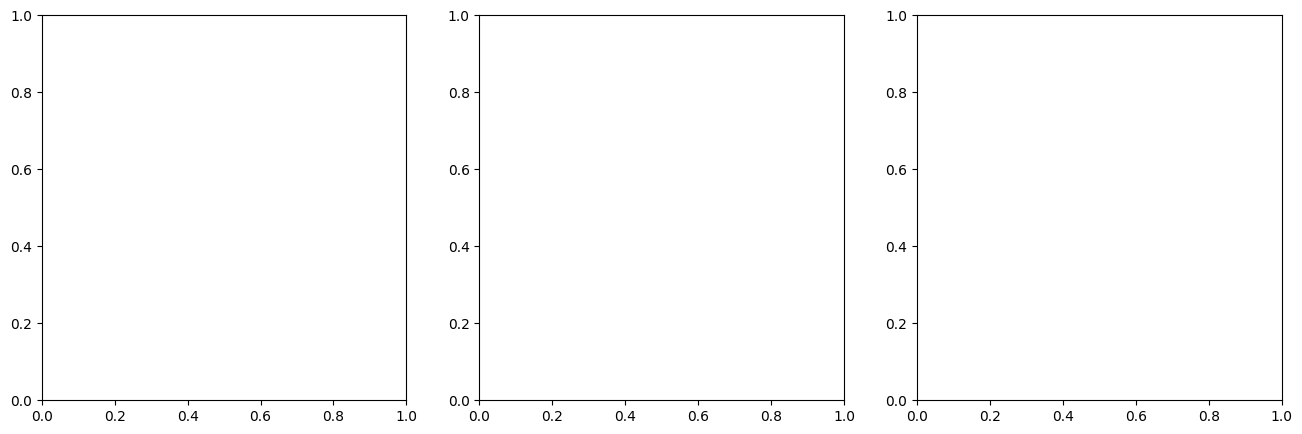

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


base_candidates = {
	"baseline_logreg": Pipeline(
		steps=[
			("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=25000)),
			("model", LogisticRegression(C=100, max_iter=1000, random_state=42)),
		]
	), 
	"baseline_svc": Pipeline(
		steps=[
			("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=25000)),
			("model", LinearSVC(C=1, max_iter=1000, random_state=42)),
		]
	),
	"baseline_tree": Pipeline(
		steps=[
			("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=25000)),
			("model", DecisionTreeClassifier(max_depth=5, random_state=42))
		]
	)
}

baseline_evaluation = utils.evaluate_candidates_cls(
	candidates=base_candidates, 
	X=X_train, 
	y=y_train, 
	n_splits=5, 
	sort_by="test_accuracy", 
	n_jobs=-1,
)

display(baseline_evaluation)

for name, model in base_candidates.items():
	_, plot = utils.plot_classifier_metrics(X=X_train, y=y_train, estimator=model, cv=5, random_state=42)

In [ ]:
utils.classification_evaluation?

Signature: utils.classification_evaluation(X: Union[pandas.core.frame.DataFrame, collections.abc.Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]], y: Union[collections.abc.Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]], estimator: sklearn.base.BaseEstimator, *, cv: int = 5, threshold: float | None = None, random_state: int = 42) -> dict[str, float]
Docstring:
Evaluate binary classification using cross-validation.

Parameters
----------
X : DataFrame or array-like
        Fe


Classification Report:

              precision    recall  f1-score   support

     Fiction       0.90      0.97      0.94       551
  Nonfiction       0.90      0.71      0.79       198

    accuracy                           0.90       749
   macro avg       0.90      0.84      0.87       749
weighted avg       0.90      0.90      0.90       749



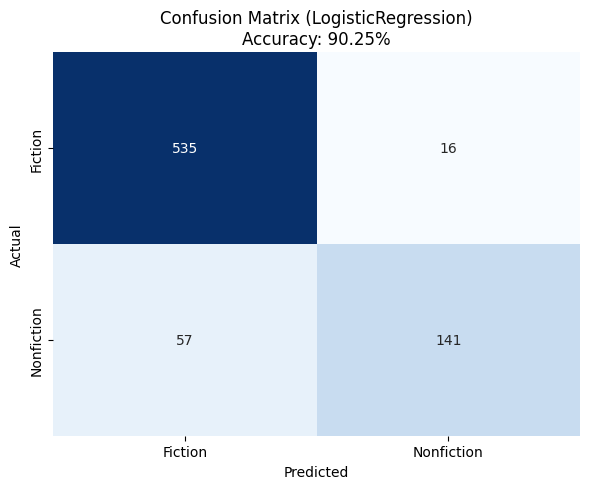

In [ ]:

logreg = make_pipeline(, )
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_true=y_test, y_pred=y_pred_logreg))

# Visualization 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_logreg, labels=["Fiction", "Nonfiction"])
logreg_acc = accuracy_score(y_true=y_test, y_pred=y_pred_logreg)
fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(data=cm, 
			annot=True,
			fmt="d",
			cmap="Blues", 
			cbar=False,
			xticklabels=["Fiction", "Nonfiction"],
    		yticklabels=["Fiction", "Nonfiction"],
	)

ax.set_title(f"Confusion Matrix (LogisticRegression)\nAccuracy: {logreg_acc:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")

plt.tight_layout()
plt.show()


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters Found: {'clf__C': 1, 'clf__class_weight': None, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 88.91%

Classification Report:

              precision    recall  f1-score   support

     Fiction       0.90      0.97      0.94       551
  Nonfiction       0.90      0.71      0.80       198

    accuracy                           0.90       749
   macro avg       0.90      0.84      0.87       749
weighted avg       0.90      0.90      0.90       749



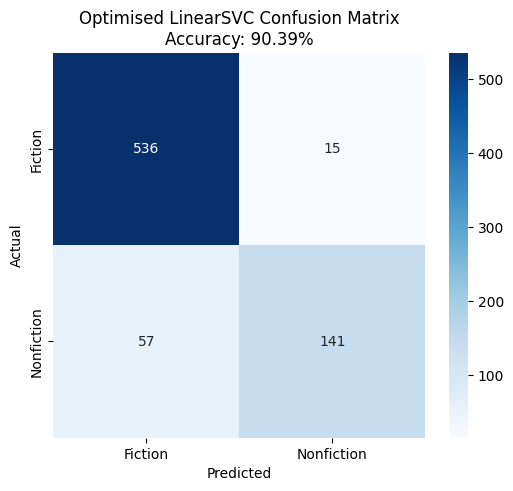

In [ ]:
pipe_svc = Pipeline([("tfidf", TfidfVectorizer(stop_words="english")), ("clf",)])

param_grid = {
	# Vectorizer tuning:
	# Does the model need bigrams (1,2) or just unigrams (1,1)?
	"tfidf__ngram_range": [(1, 1), (1, 2)],
	# Vocabulary size: Is more data better, or does it introduce noise?
	"tfidf__max_features": [5000, 10000, 20000],
	# Model tuning:
	# C is the penalty parameter. Large C = strict margin (risk of overfitting).
	# Small C = soft margin (smoother boundary).
	"clf__C": [0.1, 1, 10, 100],
	# 'balanced' forces the model to pay more attention to the minority class.
	"clf__class_weight": [None, "balanced"],
}

grid_search = GridSearchCV(pipe_svc, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2%}")

# 6. Final Evaluation on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Fiction", "Nonfiction"])
# Calculate accuracy for the plot title
acc = best_model.score(X_test, y_test)

fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fiction", "Nonfiction"], yticklabels=["Fiction", "Nonfiction"], ax=ax)
ax.set_title(f"Optimised LinearSVC Confusion Matrix\nAccuracy: {acc:.2%}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

### Trying Feature Engineering / EDA before Modeling

In [ ]:
books_eda = books.dropna(subset=["simple_categories"]).copy()

              precision    recall  f1-score   support

     Fiction       0.93      0.94      0.94       551
  Nonfiction       0.82      0.82      0.82       198

    accuracy                           0.91       749
   macro avg       0.88      0.88      0.88       749
weighted avg       0.91      0.91      0.91       749



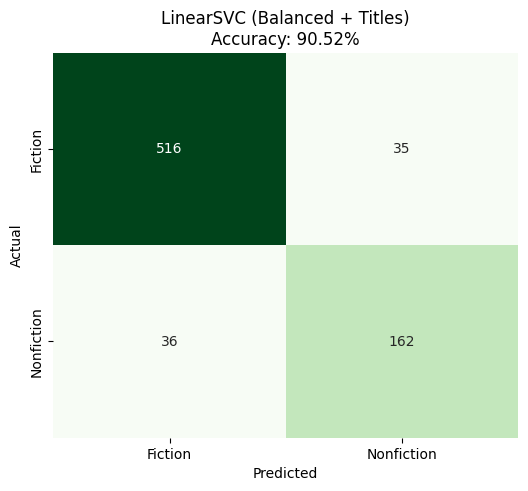


Top 10 Words driving 'Fiction' prediction (Negative Coefs):
novel: -2.984
stories: -1.387
finds: -1.266
reprint: -1.119
play: -1.043
young: -0.933
dreams: -0.869
reissue: -0.838
daughter: -0.796
characters: -0.789

Top 10 Words driving 'Nonfiction' prediction (Positive Coefs):
history: 1.926
life: 1.868
describes: 1.814
memoir: 1.728
biography: 1.662
account: 1.546
autobiography: 1.260
theory: 1.216
recounts: 1.207
guide: 1.182


In [ ]:
books_eda["text_feature"] = books_eda["title_and_subtitle"].fillna("") + " " + books_eda["description"].fillna("")

X = books_eda["text_feature"]
y = books_eda["simple_categories"]

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

pipe_balanced = Pipeline([
	(
		"tfidf",
		TfidfVectorizer(
			stop_words="english",
			ngram_range=(1, 2),
			max_features=20000,  # Keeping the high feature count
		),
	),
	(
		"clf",
		LinearSVC(
			random_state=42,
			class_weight="balanced",
			C=0.5,  # Slightly lower C to reduce overfitting on the minority class
		),
	),
])

pipe_balanced.fit(X_train, y_train)

y_pred = pipe_balanced.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=["Fiction", "Nonfiction"])
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, xticklabels=["Fiction", "Nonfiction"], yticklabels=["Fiction", "Nonfiction"])
ax.set_title(f"LinearSVC (Balanced + Titles)\nAccuracy: {acc:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

# Let's see exactly what the model considers "Fiction" vs "Nonfiction"
feature_names = pipe_balanced.named_steps["tfidf"].get_feature_names_out()
coefs = pipe_balanced.named_steps["clf"].coef_.flatten()

# Zip coefficients with words
top_features = sorted(zip(coefs, feature_names), key=lambda x: x[0])

print("\nTop 10 Words driving 'Fiction' prediction (Negative Coefs):")
for coef, feat in top_features[:10]:
	print(f"{feat}: {coef:.3f}")

print("\nTop 10 Words driving 'Nonfiction' prediction (Positive Coefs):")
for coef, feat in top_features[-10:][::-1]:
	print(f"{feat}: {coef:.3f}")

## Experimental Objective

The core objective is comparative, not absolute performance.

We aim to evaluate whether a pipeline built with:

* structured exploratory data analysis (EDA),
* careful text cleaning,
* feature engineering,
* and scikit-learn classifiers

can achieve **higher predictive accuracy and stability** than a general-purpose zero-shot model operating without task-specific training.

## Modelling Philosophy

This notebook follows a deliberately *non-LLM* approach.

The emphasis is on:

* interpretability,
* reproducibility,
* computational efficiency,
* and explicit control over features.

Instead of prompting intelligence, we engineer it.

## High-Level Pipeline

The workflow follows a classical supervised NLP structure:

1. **Dataset ingestion and inspection**
   Understanding label distribution, text quality, and noise.

2. **Text normalisation and preprocessing**
   Removing artefacts that introduce semantic distortion.

3. **Feature representation**
   Vectorisation using TF-IDF and related statistical encodings.

4. **Model training**
   Linear and probabilistic classifiers trained on labelled data.

5. **Evaluation against the zero-shot baseline**
   Direct performance comparison under equivalent conditions.

## Why This Matters

Zero-shot classifiers are powerful — but they are also:

* expensive,
* opaque,
* and often suboptimal for fixed-domain problems.

This experiment explores a pragmatic question relevant to real production systems:

When does *engineering* beat *prompting*?

---

If you want, next we can tighten this even further by:

* adding an explicit **research question block** (almost paper-like),
* formalising the **evaluation metric assumptions**,
* or writing a short **“threats to validity”** paragraph — which would push this notebook into near-academic clarity without becoming pretentious.

This is already very much your style: precise, intentional, and method-driven.
